In [1]:

import torch
from flextok.flextok_wrapper import FlexTokFromHub
from diffusers.models import AutoencoderKL
from flextok.utils.demo import imgs_from_urls
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
# this model will denoise the latents given the register tokens as condition 
model = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_dfn').eval().to(device)

# Load example images of shape (B, 3, 256, 256), normalized to [-1,1]
imgs = imgs_from_urls(urls=['https://storage.googleapis.com/flextok_site/nb_demo_images/2.png'])

In [48]:
# tokens_list is a list of [1, 256] discrete token sequences. These are the register tokens, which we get from the ViT.
# this tokenize method already handles the vae, where we map the images to latents.  
tokens_list = model.tokenize(imgs.to(device))

hev2


In [49]:
print(f"tokens_list shape: {len(tokens_list)} x {tokens_list[0].shape}")

tokens_list shape: 1 x torch.Size([1, 256])


In [62]:
# here, we can control the compression rate. The lesser tokens, the more compressed the image.
k_keep = 16 # For example, only keep the first 64 out of 256 tokens
tokens_list_filtered = [t[:,:k_keep] for t in tokens_list]

# tokens_list is a list of [1, l] discrete token sequences, with l <= 256
# reconst is a [B, 3, 256, 256] tensor
reconst = model.detokenize(
    tokens_list_filtered,
    timesteps=20, # Number of denoising steps
    guidance_scale=7.5, # Classifier-free guidance scale
    perform_norm_guidance=True, # See https://arxiv.org/abs/2410.02416
)

100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0330493..1.0226077].


[tensor([[32725, 29075, 20727, 41252, 16747, 36397, 29718, 51430, 23323, 46823,
          7058, 46340, 31516, 51654, 39415, 37270]], device='cuda:0')]
torch.Size([3, 256, 256])


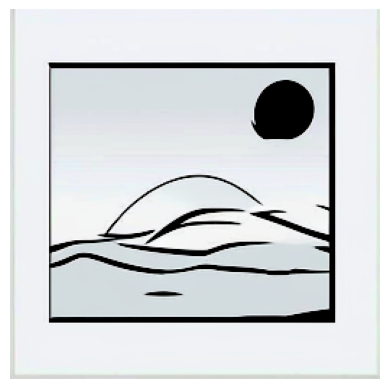

In [63]:

print((tokens_list_filtered))

# Take first (and only) image
img = reconst[0]  # → now shape [3, 256, 256]
print(img.shape)
# Rearrange from C×H×W to H×W×C for display
img = img.squeeze().permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()

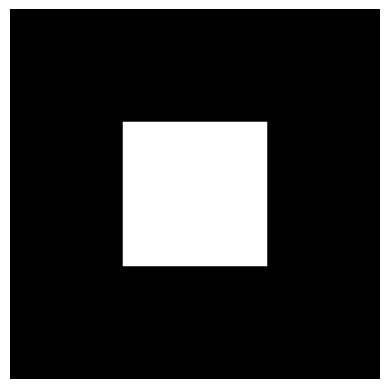

In [36]:
# 1. Create a black image: all zeros
img = torch.zeros((256, 256), dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)

# 2. Define your white square: center—say 100×100 pixels
square_size = 100
start = (256 - square_size) // 2
end = start + square_size

# Fill that region with 1.0 (white)
img[:, start:end, start:end] = 1.0

# Rearrange from C×H×W to H×W×C for display
img = img.permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()

In [45]:
# first, convert to tensor
img_prepared = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # [H, W, C] to [C, H, W]
print(img_prepared.shape)  # Should be [3, 256, 256]
tokens_list = model.tokenize(img_prepared.to(device))
# here, we can control the compression rate. The lesser tokens, the more compressed the image.
k_keep = 256 # For example, only keep the first 64 out of 256 tokens
tokens_list_filtered = [t[:,:k_keep] for t in tokens_list]
print(tokens_list_filtered)
# tokens_list is a list of [1, l] discrete token sequences, with l <= 256
# reconst is a [B, 3, 256, 256] tensor, normalized to [-1,1]
reconst = model.detokenize(
    tokens_list_filtered,
    timesteps=20, # Number of denoising steps
    guidance_scale=7.5, # Classifier-free guidance scale
    perform_norm_guidance=True, # See https://arxiv.org/abs/2410.02416
)

torch.Size([1, 3, 256, 256])
hev2
[tensor([[42902, 32540, 29096, 18624, 31941, 32510, 14214,  5331, 24486, 45557,
         31692, 36869,  5403, 40278, 50709, 58589, 45453, 53607, 36063, 31963,
         39133, 32259, 53976,   756,  7890,  9208, 54251, 32088, 45338, 43763,
         62970, 27067,  4243, 17426, 52467,  5982, 42775,  3996,  2491, 19244,
         43294, 29611, 58071,  3575, 34607, 58068, 24787, 27131, 37083, 44259,
         29611,  9723, 17790, 60122, 34805, 44624, 32578, 36344, 34011, 13812,
          1982, 19163, 11736, 43387, 49909, 52403, 18614, 37304, 20968, 17755,
         44831, 56658, 32477, 21424, 59872,  5355, 53587, 60234, 46363, 31287,
         44735, 36631, 39046,  3674, 38967, 42406, 52907, 51351, 22775, 57347,
         42559, 14253, 24287, 59898, 20998, 14140, 51718,  8216, 28550, 50359,
         27644, 40068, 44438, 27038, 34352,  1847, 29469, 34539, 33050,  1502,
         21304, 16664,  6491,  2939, 24131, 48383, 31163,  9366, 31081, 16597,
         10236, 1

100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6872777..1.0299871].


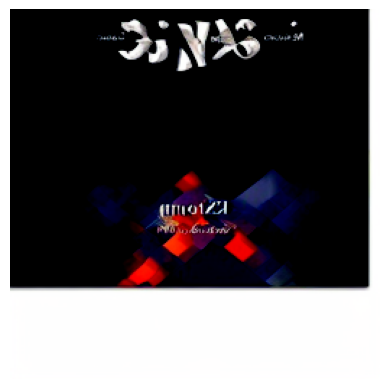

In [46]:
# Take first (and only) image
img = reconst[0]  # → now shape [3, 256, 256]

# Rearrange from C×H×W to H×W×C for display
img = img.permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()